In [1]:
%cd "/home/plent/Documenten/Gitlab/NeuralODEs/symplectic_adjoint"
from developing_sbml.sbml_load import *
import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt
import numpy as np
import jax.numpy as jnp
import jax

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import matplotlib.pyplot as plt
import optax
import pandas as pd
import logging
import sys
sys.path.append('jax_implementation/developing_sbml/')

from developing_sbml.jax_kinetic_model import NeuralODE, JaxKineticModel

import jax
# needed if system is stiff
jax.config.update("jax_enable_x64", True)

/home/plent/Documenten/Gitlab/NeuralODEs/symplectic_adjoint


In [2]:
### load model
filepath="jax_implementation/developing_sbml/sbml_models/working_models/BIOMD0000000051_url.xml"
model=load_sbml_model(file_path=filepath)


S=get_stoichiometric_matrix(model)


y0=get_initial_conditions(model)
species_names=list(y0.keys())

y0=jnp.array(list(y0.values()))
##recreate create_fluxes, but then for jax
v,v_symbol_dictionaries,local_params=create_fluxes_v(model)
met_point_dict=construct_flux_pointer_dictionary(v_symbol_dictionaries,list(S.columns),list(S.index))

ts=jnp.arange(0,5,0.1)
JaxKmodel = NeuralODE(v=v, S=S, 
                  met_point_dict=met_point_dict,
                  v_symbol_dictionaries=v_symbol_dictionaries)

JaxKmodel=jax.jit(JaxKmodel)

S.index


17:01:00,041 - developing_sbml.sbml_load - INFO - Number of internal inconsistencies: 0
Number of species: 18
Number of reactions: 48
Number of global parameters 7
Number of constant boundary metabolites:  0
Number of lambda function definitions:  0
Number of assignment rules 7
17:01:00,054 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
17:01:00,054 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
17:01:00,055 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Index(['cpep', 'cglcex', 'cg6p', 'cpyr', 'cf6p', 'cg1p', 'cpg', 'cfdp',
       'csed7p', 'cgap', 'ce4p', 'cxyl5p', 'crib5p', 'cdhap', 'cpgp', 'cpg3',
       'cpg2', 'cribu5p'],
      dtype='object')

In [3]:
## load data and format

data=pd.read_excel("jax_implementation/KIMODATAID30_v1.xlsx",sheet_name=1,header=6,index_col=0)
data=data.iloc[2:,:]
data=data.rename({'G6P [mM]':"cg6p","F6P [mM]":"cf6p",'FDP [mM]':'cfdp',
                  'GAP [mM]':'cgap','PEP [mM]':'cpep','PYR [mM]':'cpyr',
                  '6PG [mM]':'6pg','G1P [mM]':'cg1p'},axis=1)
data=data.apply(pd.to_numeric)


ts=jnp.array(list(data.index))

names=np.intersect1d(species_names,data.columns,return_indices=True)

indices=names[1]
data=data[names[0]]
species_names=np.array(species_names)
#now format the data such that order is the same
# data=data.reindex(columns=species_names[names[1]])
species_names=species_names[indices]


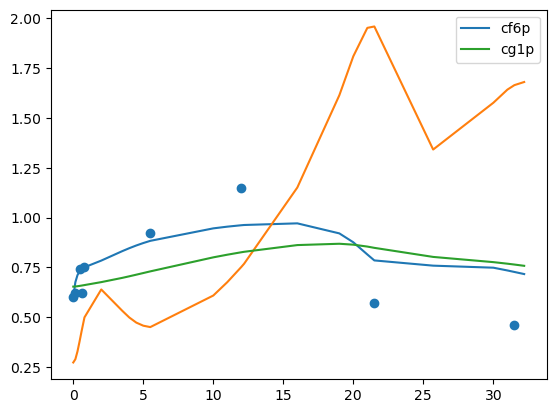

In [9]:

# #parameters are not yet defined
params=get_global_parameters(model)
params={**local_params,**params}


# # # print(v_local_param_dict)
ys=JaxKmodel(ts=ts,
      y0=y0,
      params=params)

# ys_data=JaxKmodel(ts=ts,
#       y0=y0_data,
#       params=params)
ys=ys[:,indices]

plt.plot(ts,ys[:,0],label=species_names[0])
plt.plot(ts,ys[:,1])
plt.plot(ts,ys[:,2],label=species_names[2])

plt.scatter(ts,data.iloc[:,0])
# plt.scatter(ts,data.iloc[:,2],label="g1p")

plt.legend()

In [11]:

mask = ~jnp.isnan(np.array(data))

def loss_func(params,ts,ys):

    """A very simple loss function, later we need to add functionality for missing data"""
    
    mask=~jnp.isnan(jnp.array(data))
    yscale=jnp.nanmax(ys,axis=0)-jnp.nanmin(ys,axis=0)
    ys=ys*(1/yscale)
    # print(mask)

    y_pred=JaxKmodel(ts,y0,params)
    y_pred=y_pred[:,0:7]

    ys = jnp.where(mask, ys, 0)
    y_pred = jnp.where(mask, y_pred, 0)
    
    # Count the non-NaN values to adjust the mean calculation
    non_nan_count = jnp.sum(mask)
    
    # Apply the mask to ignore NaNs in ys and corresponding y_pred
    # y_pred=y_pred[mask]

    non_nan_count = jnp.sum(mask)
    loss = jnp.sum((y_pred - ys) ** 2) / non_nan_count

    return loss

# grads=jax.jit(jax.grad(loss_func,0))(params,ts,ys)
loss_func(params,ts,ys)

@jax.jit
def update(opt_state,params,ts,ys):
    """Update rule for the gradients for parameters"""
    loss=loss_func(params,ts,ys)
    grads=jax.jit(jax.grad(loss_func,0))(params,ts,ys) #loss w.r.t. parameters
    updates,opt_state=optimizer.update(grads,opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state,params,loss,grads





In [6]:
epochs=5
params_init=params
lr=1e-3
optimizer = optax.adabelief(lr)
opt_state = optimizer.init(params_init)
for _ in range(epochs):
    try:
        opt_state,params_init,loss,grads=update(opt_state,params_init,ts,ys)
        print(loss)
    except Exception as e:
        logging.error(f"Error for {i}: {e}")


1.3446255295668101
16:59:32,026 - jax._src.callback - ERROR - jax.pure_callback failed
Traceback (most recent call last):
  File "/home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/callback.py", line 77, in pure_callback_impl
    return callback(*args)
           ^^^^^^^^^^^^^^^
  File "/home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/jax/_src/callback.py", line 65, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/plent/anaconda3/envs/jax_env/lib/python3.12/site-packages/equinox/_errors.py", line 70, in raises
    raise EqxRuntimeError(msgs[_index.item()])
equinox._errors.EqxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


NameError: name 'i' is not defined